In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 100

Загрузим данные из csv и посмотрим на первые строки

In [2]:
df = pd.read_csv(r"D:\PROJECTS\Final_work\5_final_project\csv\taxi.csv")
df.head(5)


tpep_pickup_datetime  passenger_count  trip_distance  fare_amount  \
0  2020-01-22 16:40:49                1           1.32          7.5   
1  2020-01-22 16:40:49                1           1.77          8.5   
2  2020-01-22 16:40:50                1           2.84         19.0   
3  2020-01-22 16:40:50                2           3.00         13.0   
4  2020-01-22 16:40:50                1           1.11          8.0   

   tip_amount  total_amount  
0        0.00         11.80  
1        2.56         15.36  
2        0.00         23.30  
3        0.00         17.30  
4        1.00         13.30

Заметно медленне чем ClickHouse работает Pandas) объем данных дает о сбе знать, Excel к слову приказал долго жить и был таков) 

Для дальнейшего анализа нужно выбросить еще пару столбцов, оставив расстояние, чаевые и количество пассажиров. (избыточные столбцы были оставлены изначально лишь как предположительно относящиеся к оплате)

In [3]:
df=df.drop([ 'tpep_pickup_datetime','fare_amount','total_amount'], axis=1)

## Анализ

In [4]:
df=df.drop_duplicates() #удалим повторяющиеся строки

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 517155 entries, 0 to 6404999
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   passenger_count  517155 non-null  int64  
 1   trip_distance    517155 non-null  float64
 2   tip_amount       517155 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 15.8 MB


In [6]:
df.describe()

passenger_count  trip_distance     tip_amount
count    517155.000000  517155.000000  517155.000000
mean          2.258350       7.583833       5.723246
std           1.670319     292.418481       5.809026
min           0.000000     -30.620000     -91.000000
25%           1.000000       2.160000       2.300000
50%           2.000000       5.010000       4.460000
75%           3.000000      10.330000       7.980000
max           9.000000  210240.060000    1100.000000

размах огромный, особенно у расстояния.

In [7]:
df = df.drop(df[df['trip_distance'] < 0].index)# удалим строки с отрицательными значениями
df = df.drop(df[df['tip_amount'] < 0].index)

<Axes: >

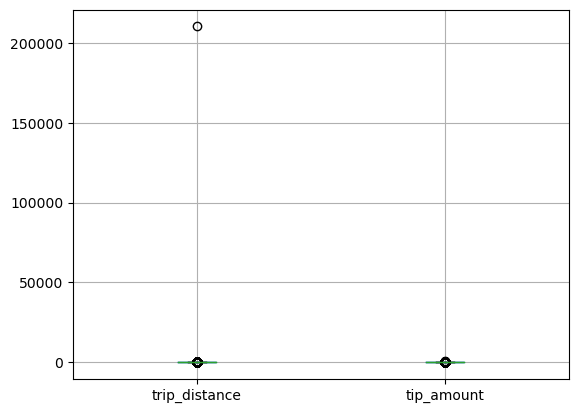

In [8]:
df.boxplot(column=['trip_distance','tip_amount'])

In [9]:
df.describe()

passenger_count  trip_distance     tip_amount
count    515939.000000  515939.000000  515939.000000
mean          2.263407       7.623051       5.737661
std           1.668901     292.761556       5.805873
min           0.000000       0.000000       0.000000
25%           1.000000       2.180000       2.320000
50%           2.000000       5.040000       4.460000
75%           3.000000      10.350000       7.980000
max           9.000000  210240.060000    1100.000000

Удалили выбросы методом медквартильно размаха

In [10]:
column_names = [
    'trip_distance',
    'tip_amount']


for x in column_names:
    q75 = np.percentile(df.loc[:,x],75)
    q25 = np.percentile(df.loc[:,x],25)
    IQR = q75-q25
    max = q75+(1.5*IQR)
    min = q25-(1.5*IQR)
    df.loc[df[x] < min,x] = np.nan
    df.loc[df[x] > max,x] = np.nan
df = df.dropna(axis = 0)

<Axes: ylabel='Density'>

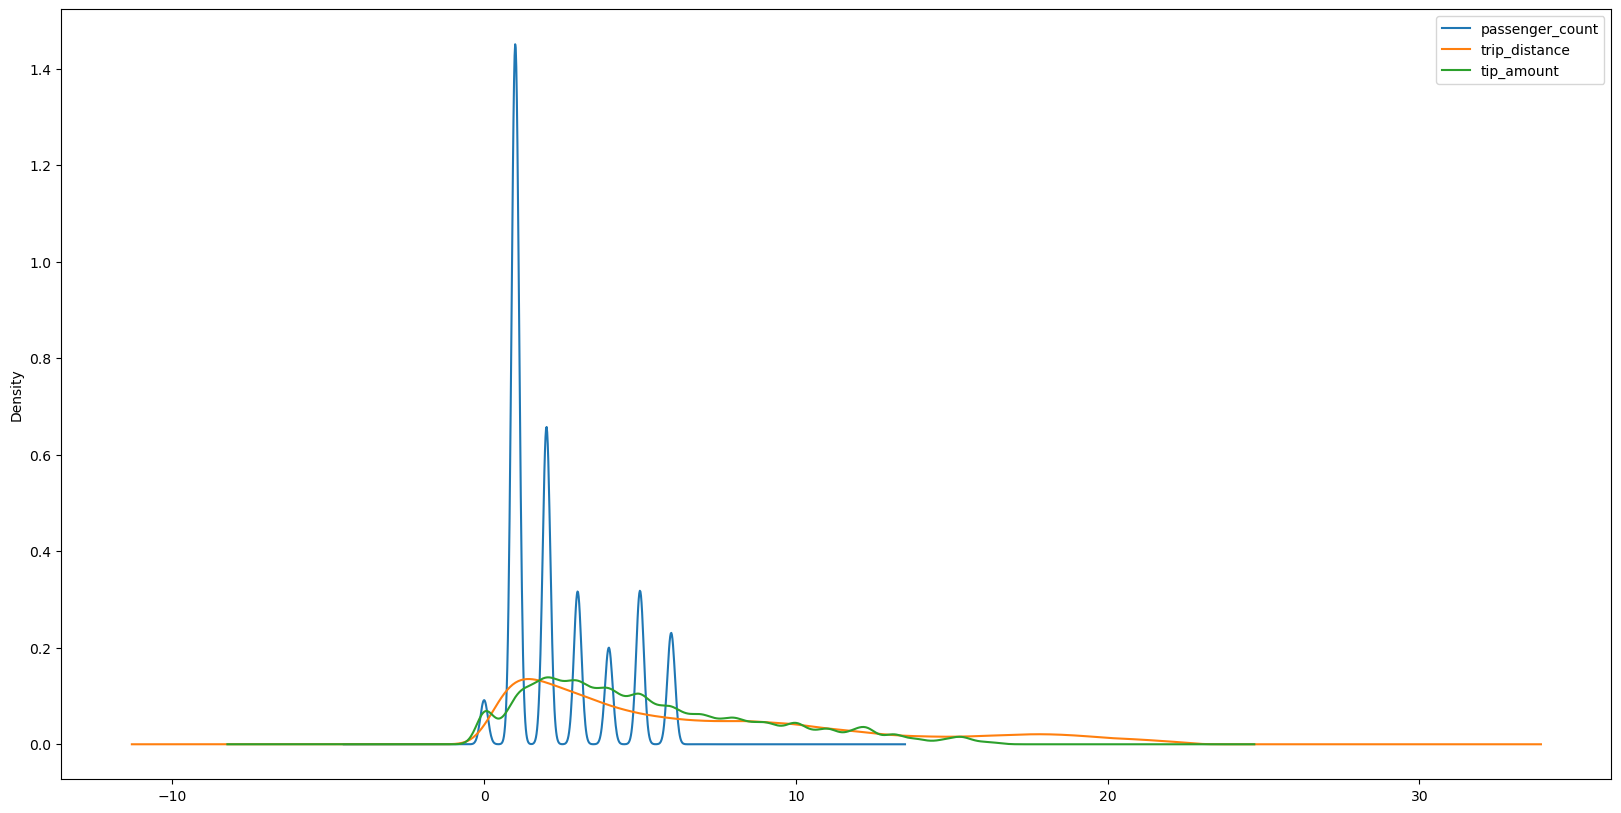

In [11]:
df.plot.kde(figsize=(20, 10))

Долго все делается, воспользуемся частью данных из df

<Axes: xlabel='trip_distance', ylabel='tip_amount'>

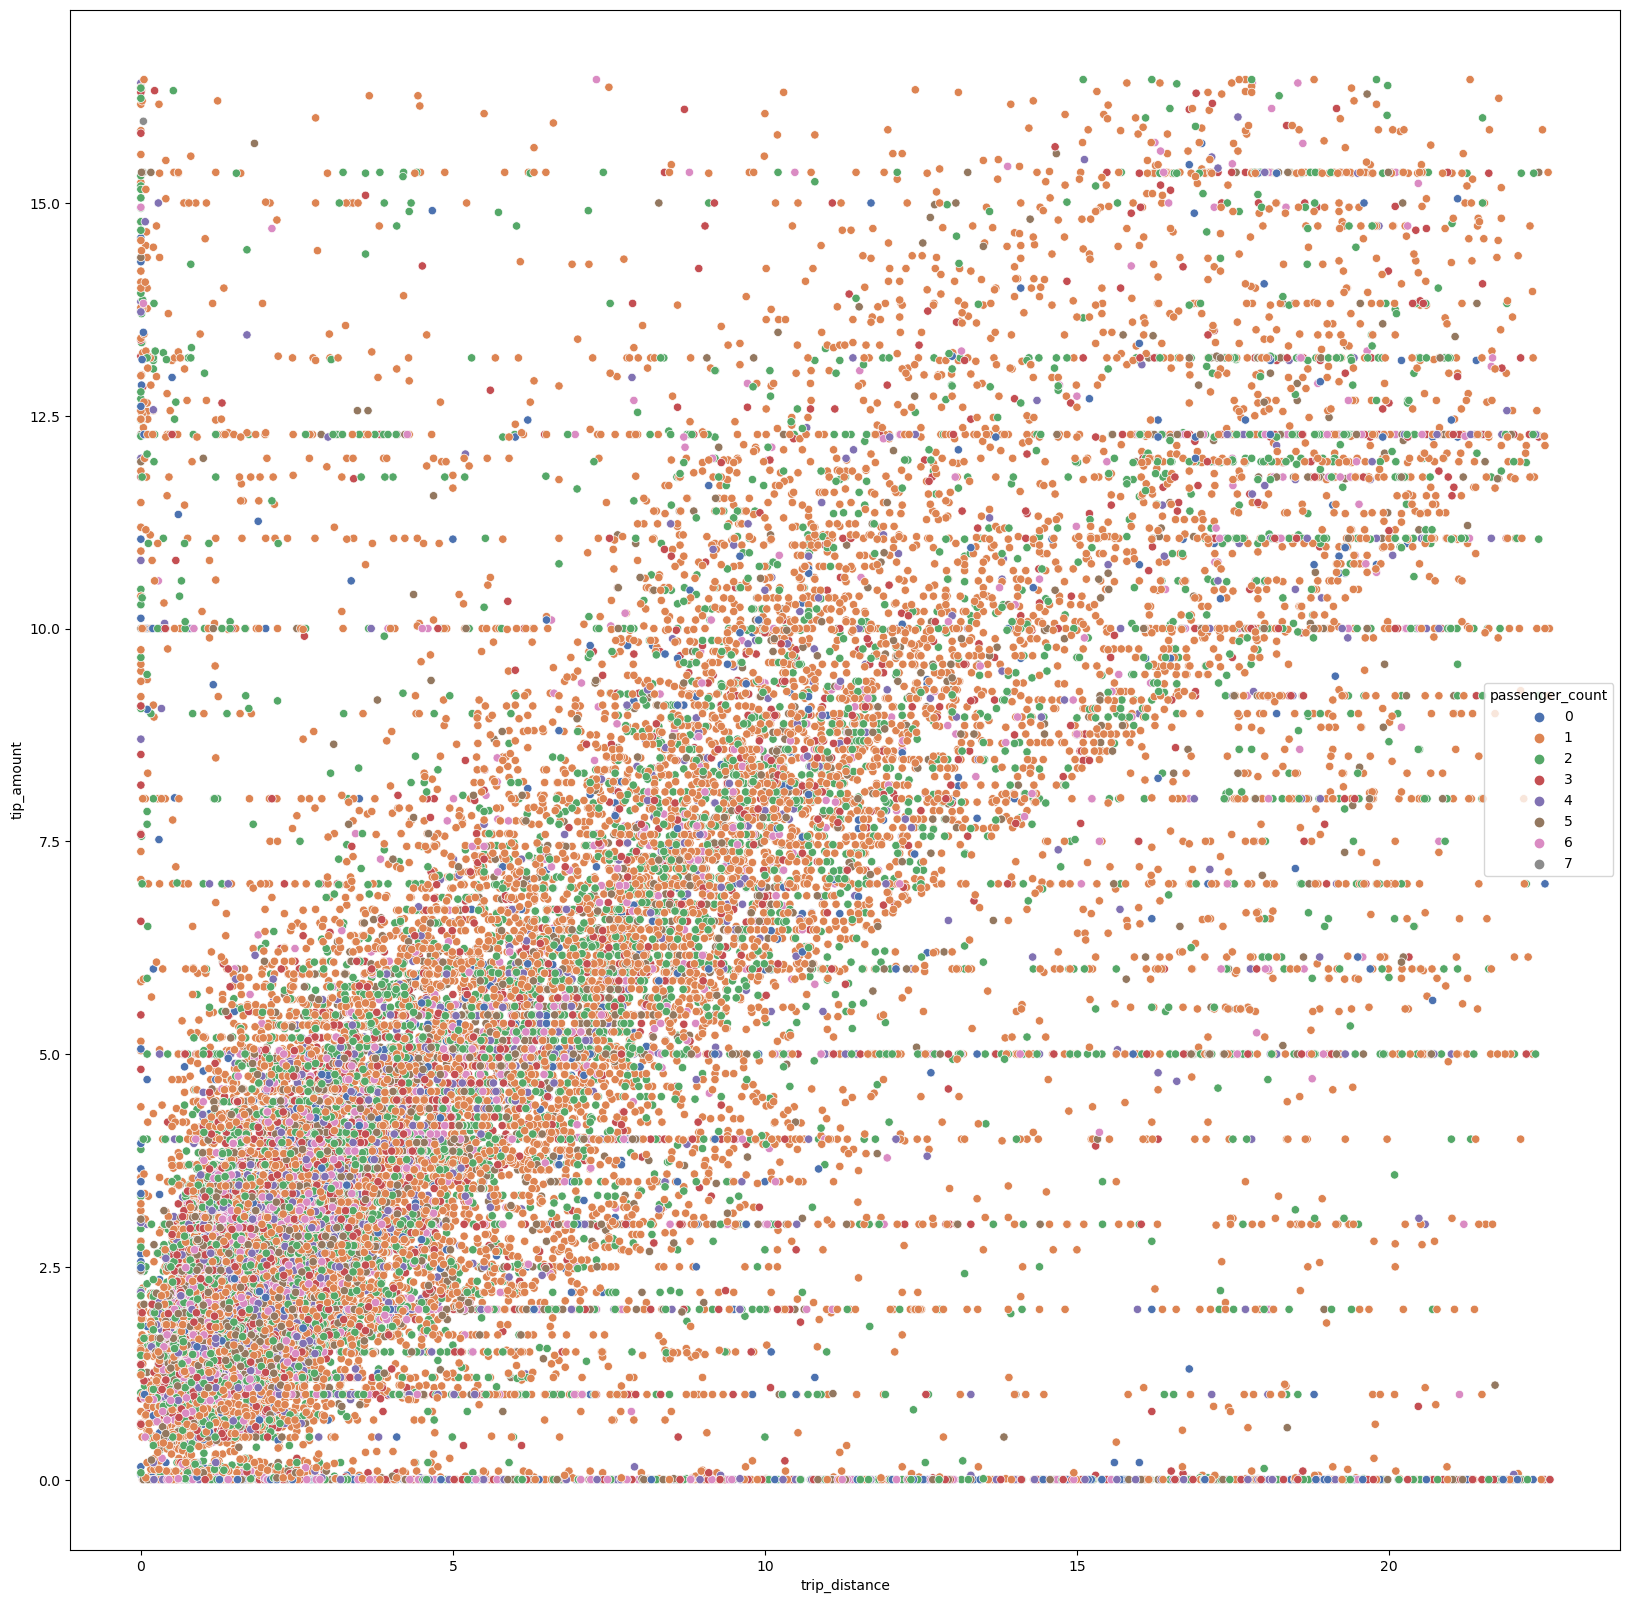

In [30]:
df_sample = df.sample(25000)

fig, scatter = plt.subplots(figsize = (20,20))
sns.scatterplot(x="trip_distance", y="tip_amount",hue = "passenger_count", palette='deep',
                               data=df_sample)

<Axes: ylabel='Density'>

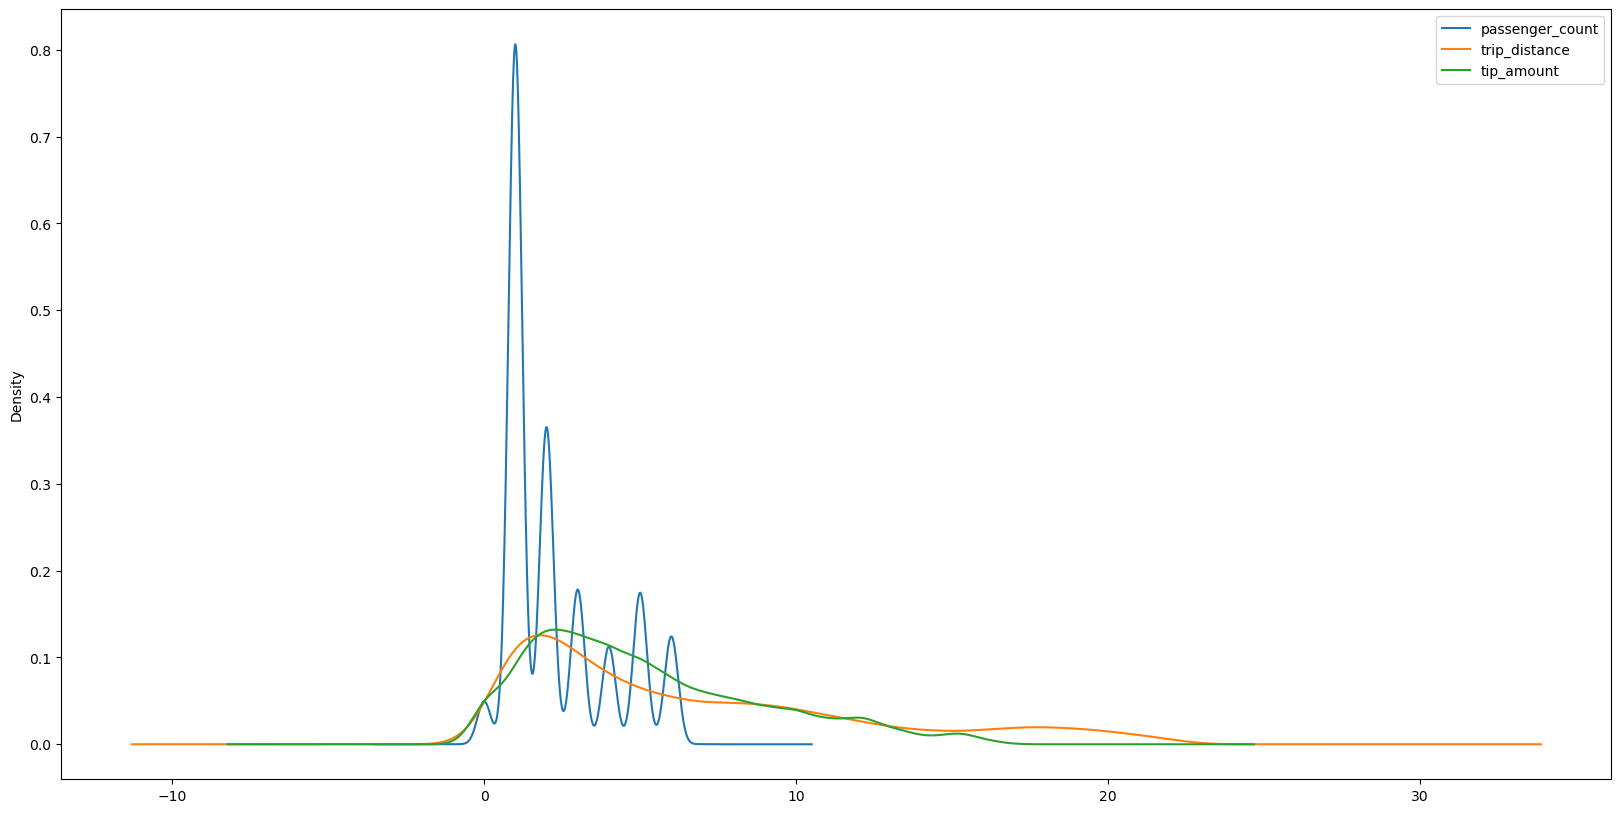

In [31]:
df_sample.plot.kde(figsize=(20, 10))

Распределения ядра  полного датасета и выборки из него похожи, значит можно считать результаты полученные на семпле результатами обьясняющими зависимости в генеральной совокупности.

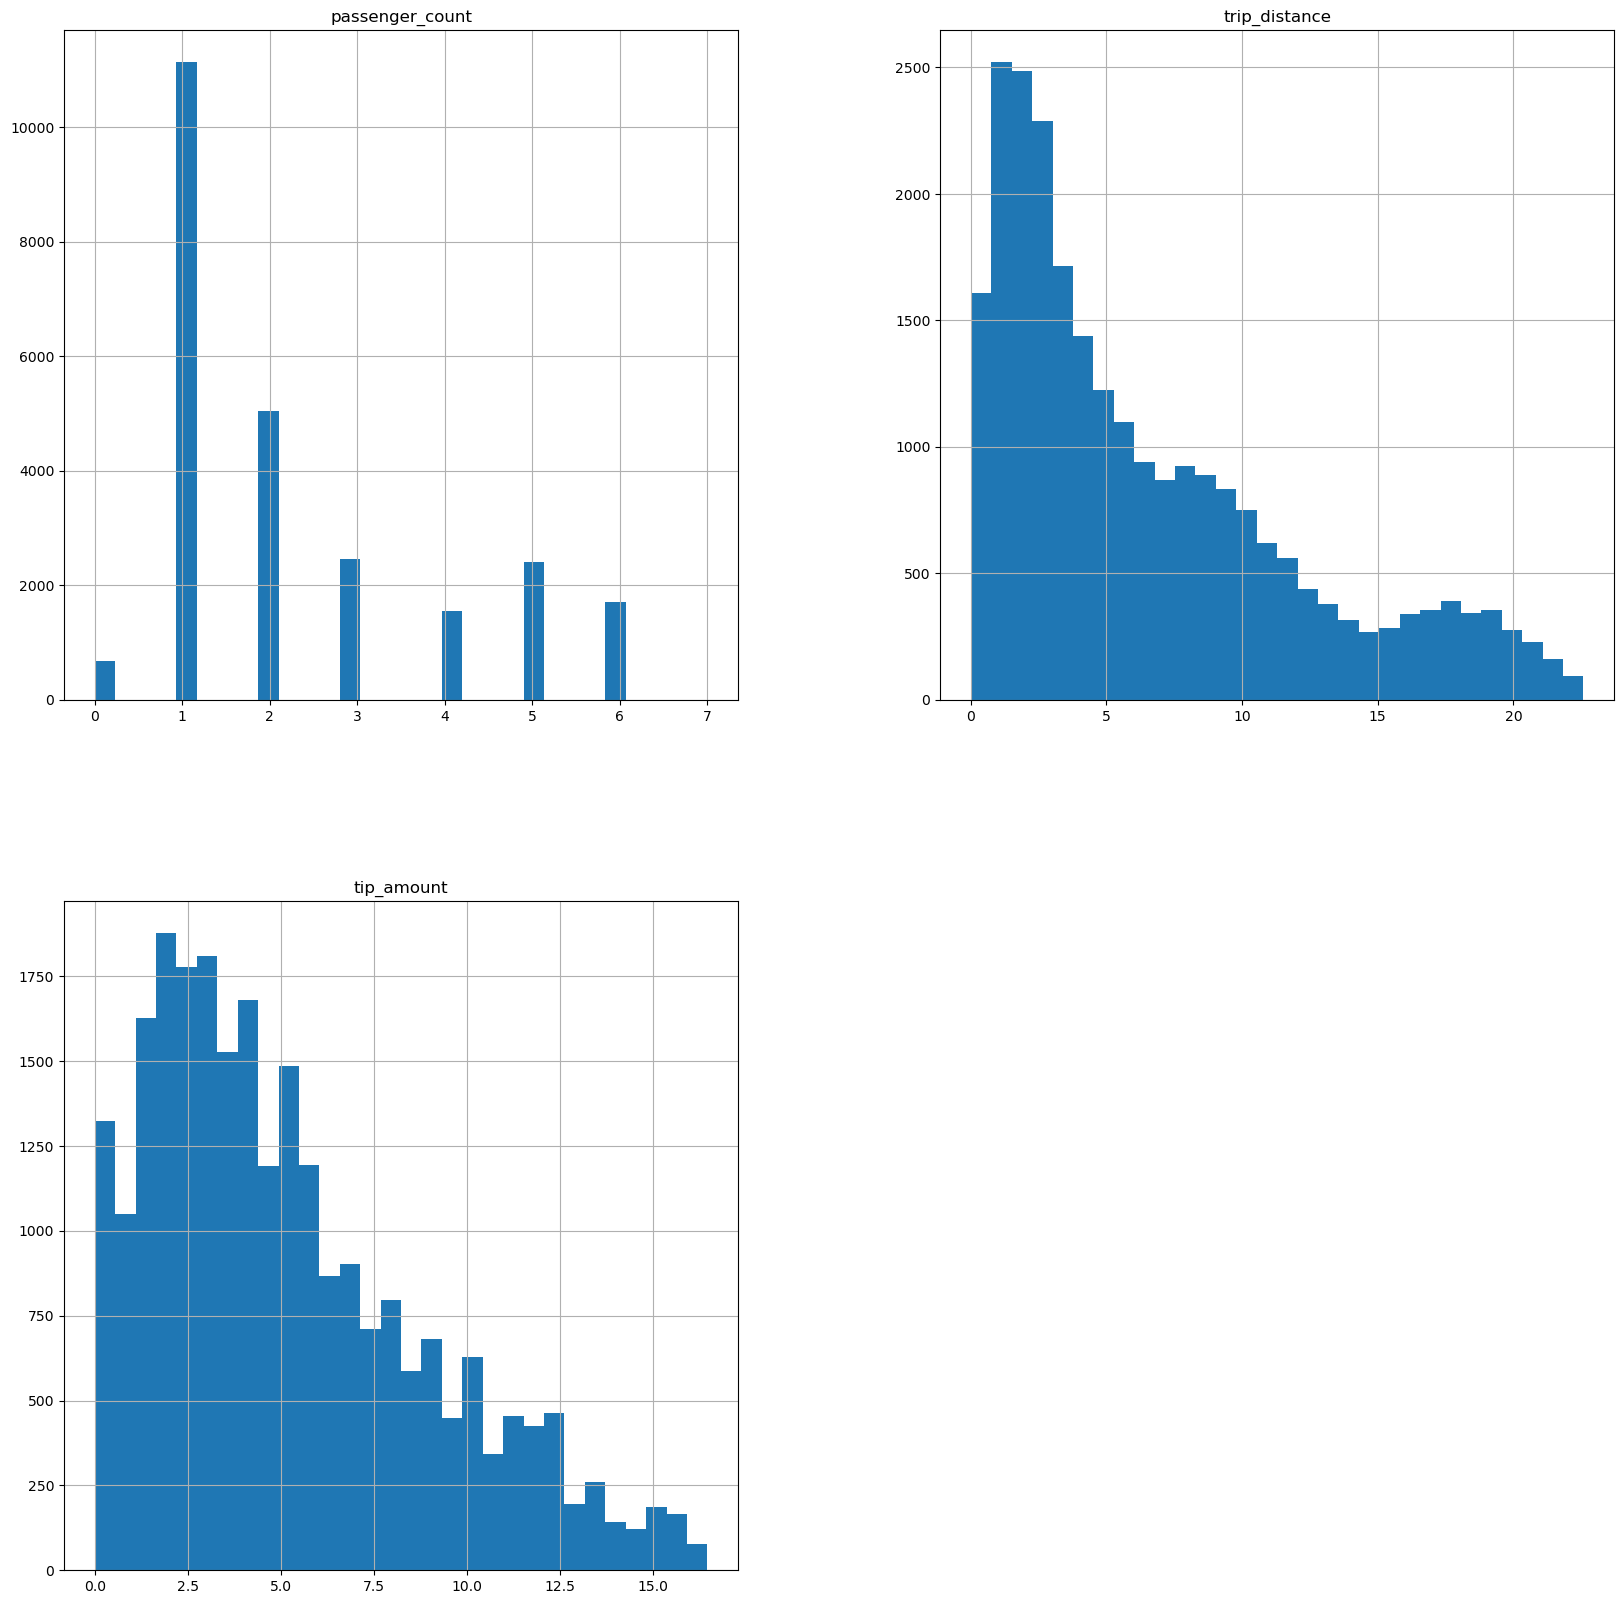

In [32]:
df_sample.hist(bins=30, figsize = (20,20))
plt.show()

Большинство поездок 1 пассажиром, до 5 км, с чаевыми от 0 до 5 у.е 

Посмотрим корреляцию на всем датасете

<Axes: >

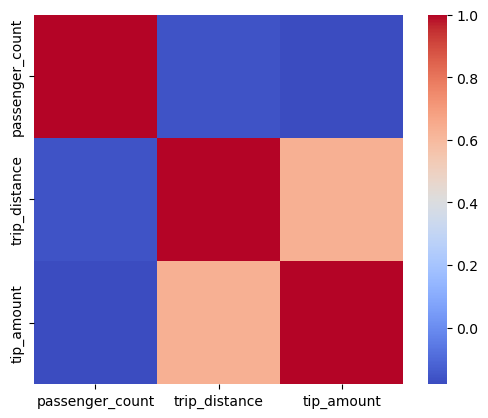

In [34]:
sns.heatmap(df.corr(),cmap= 'coolwarm',square=True)

## Видно что чаевые как-то зависят от расстояния и никак не зависят от количества пассажиров

Посмотрим зависимости чаевых от расстояния поближе, и "проверим" коэффициент корреляции нарисовав линию

C:\Users\sever\AppData\Local\Temp\ipykernel_11536\3001042485.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="trip_distance", y="tip_amount", palette='deep',


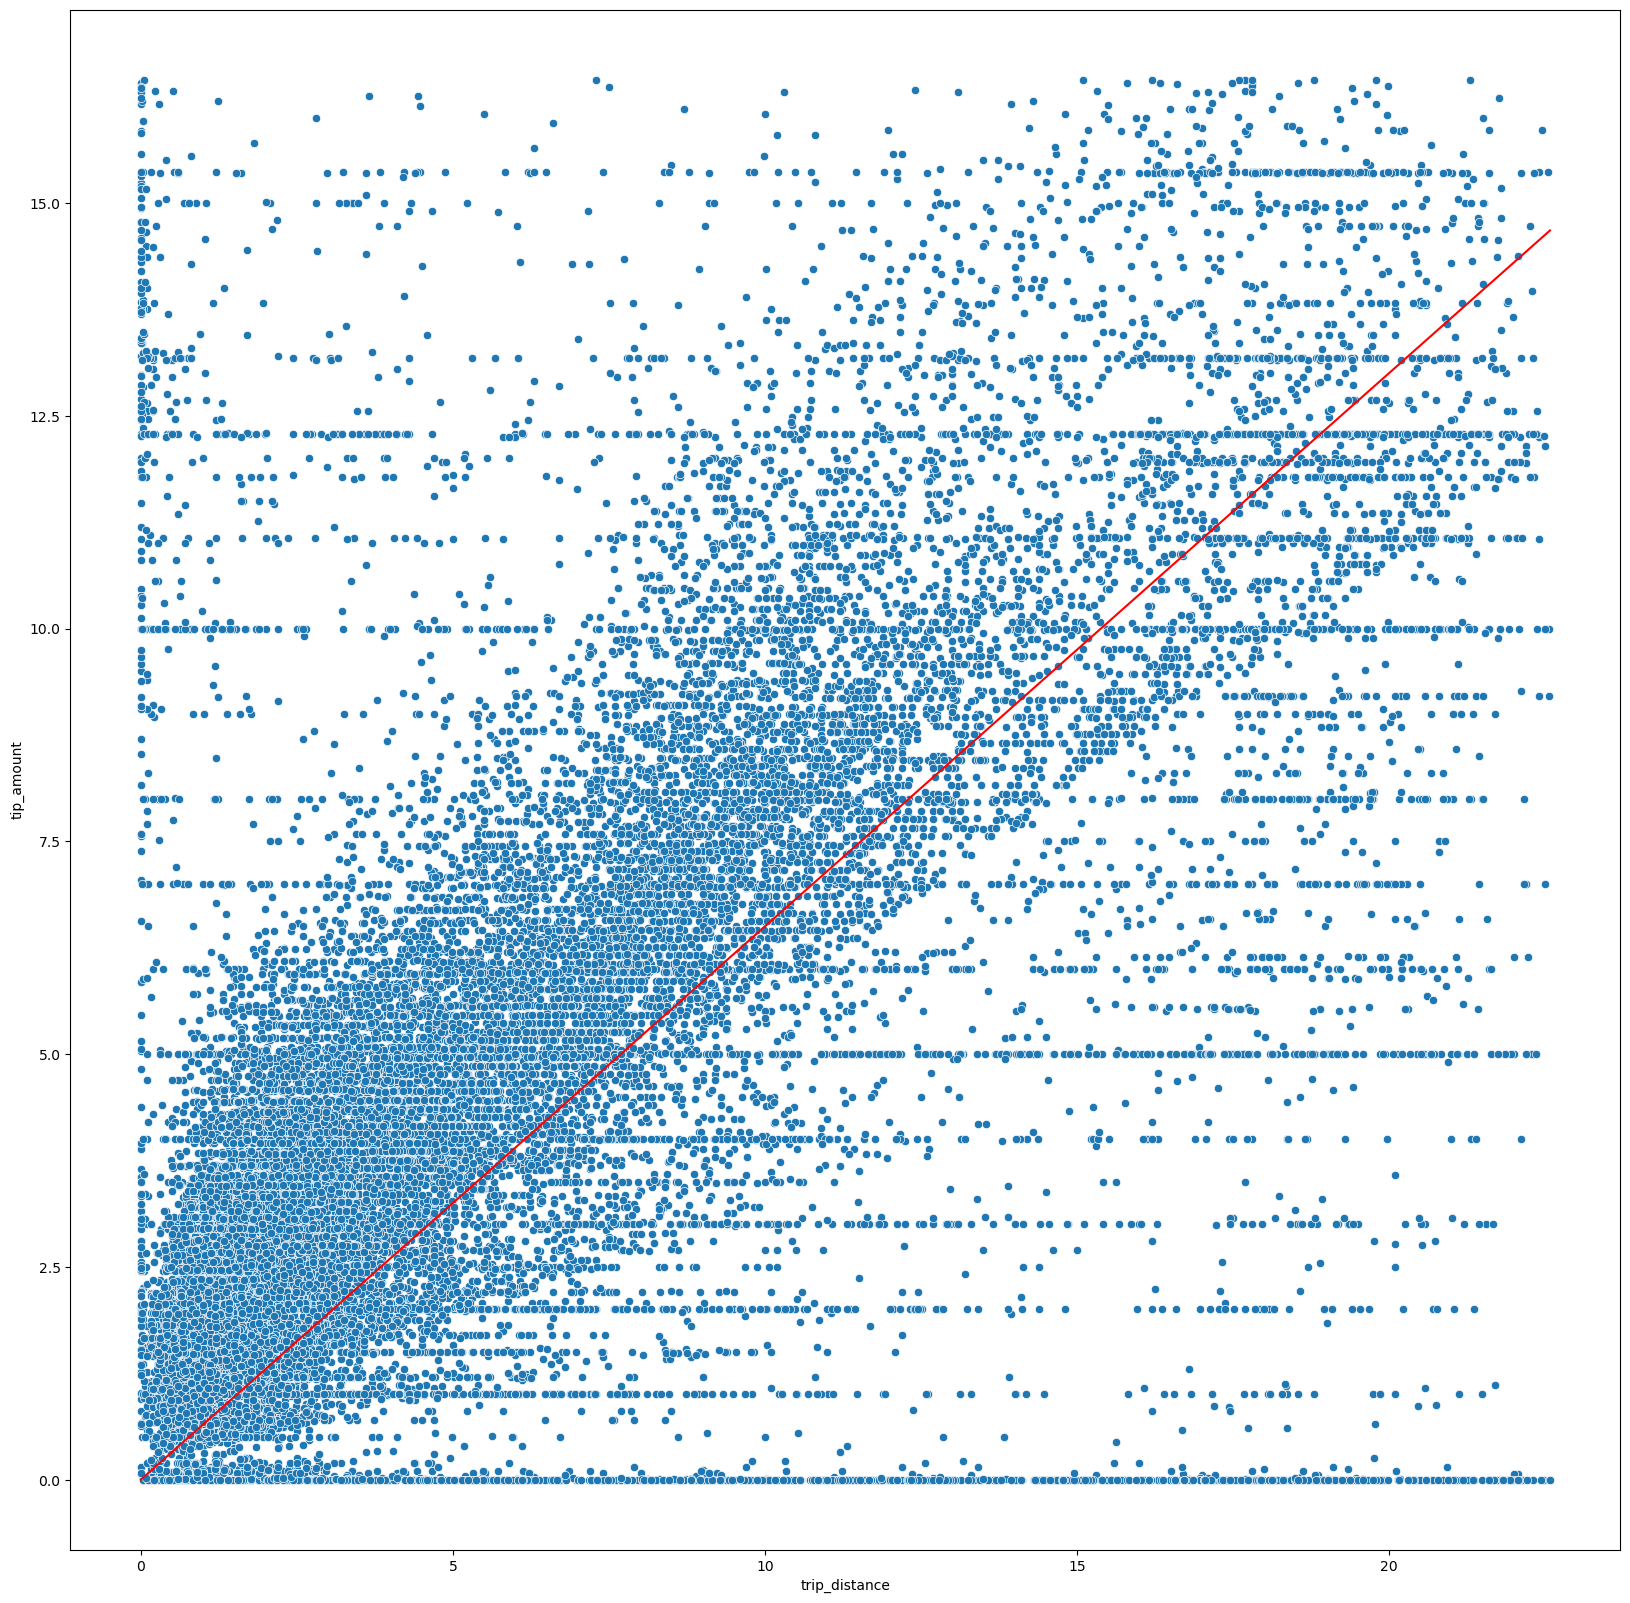

In [36]:
fig, scatter = plt.subplots(figsize = (20,20))
sns.scatterplot(x="trip_distance", y="tip_amount", palette='deep',
                               data=df_sample)

x = np.linspace(df_sample['trip_distance'].min(), df_sample['trip_distance'].max(), 100)
y = 0.65 * x 

# Добавим примрную линию на график
plt.plot(x, y, color='red')
plt.show()

## Заключение
Можно заметить некую приблизительню линейную зависимость между расстоянием и величиной чаевых, коэффииент зависимости чаевых от расстояния варьируется от примерно 0,6 до 1(тепловая карта корелляции по всем данным демонстрировала как раз примерно 0,6 - 0.7) в основной массе. Если и аппроксимировать данные, то очень толстой линией. Но диспресия признаков достаточно большая, не знаю насколько правильно будет выглядеть вся эта аналитическая вакханалия, но определенно опыт манипуляции и анализа больших данных нужно как-то набирать).

P.S. взяв семпл от семпла ничего кардинально не улучшилось, линия стала лучше, но 1500 строк от 500000 это вряд ли "реперезентативно". Вариации чаевых и расстояний не представляют заметной зависимости, особенно в части самых частых значений.

C:\Users\sever\AppData\Local\Temp\ipykernel_11536\603611613.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="trip_distance", y="tip_amount", palette='deep',data=df_sample2)


<Axes: xlabel='trip_distance', ylabel='tip_amount'>

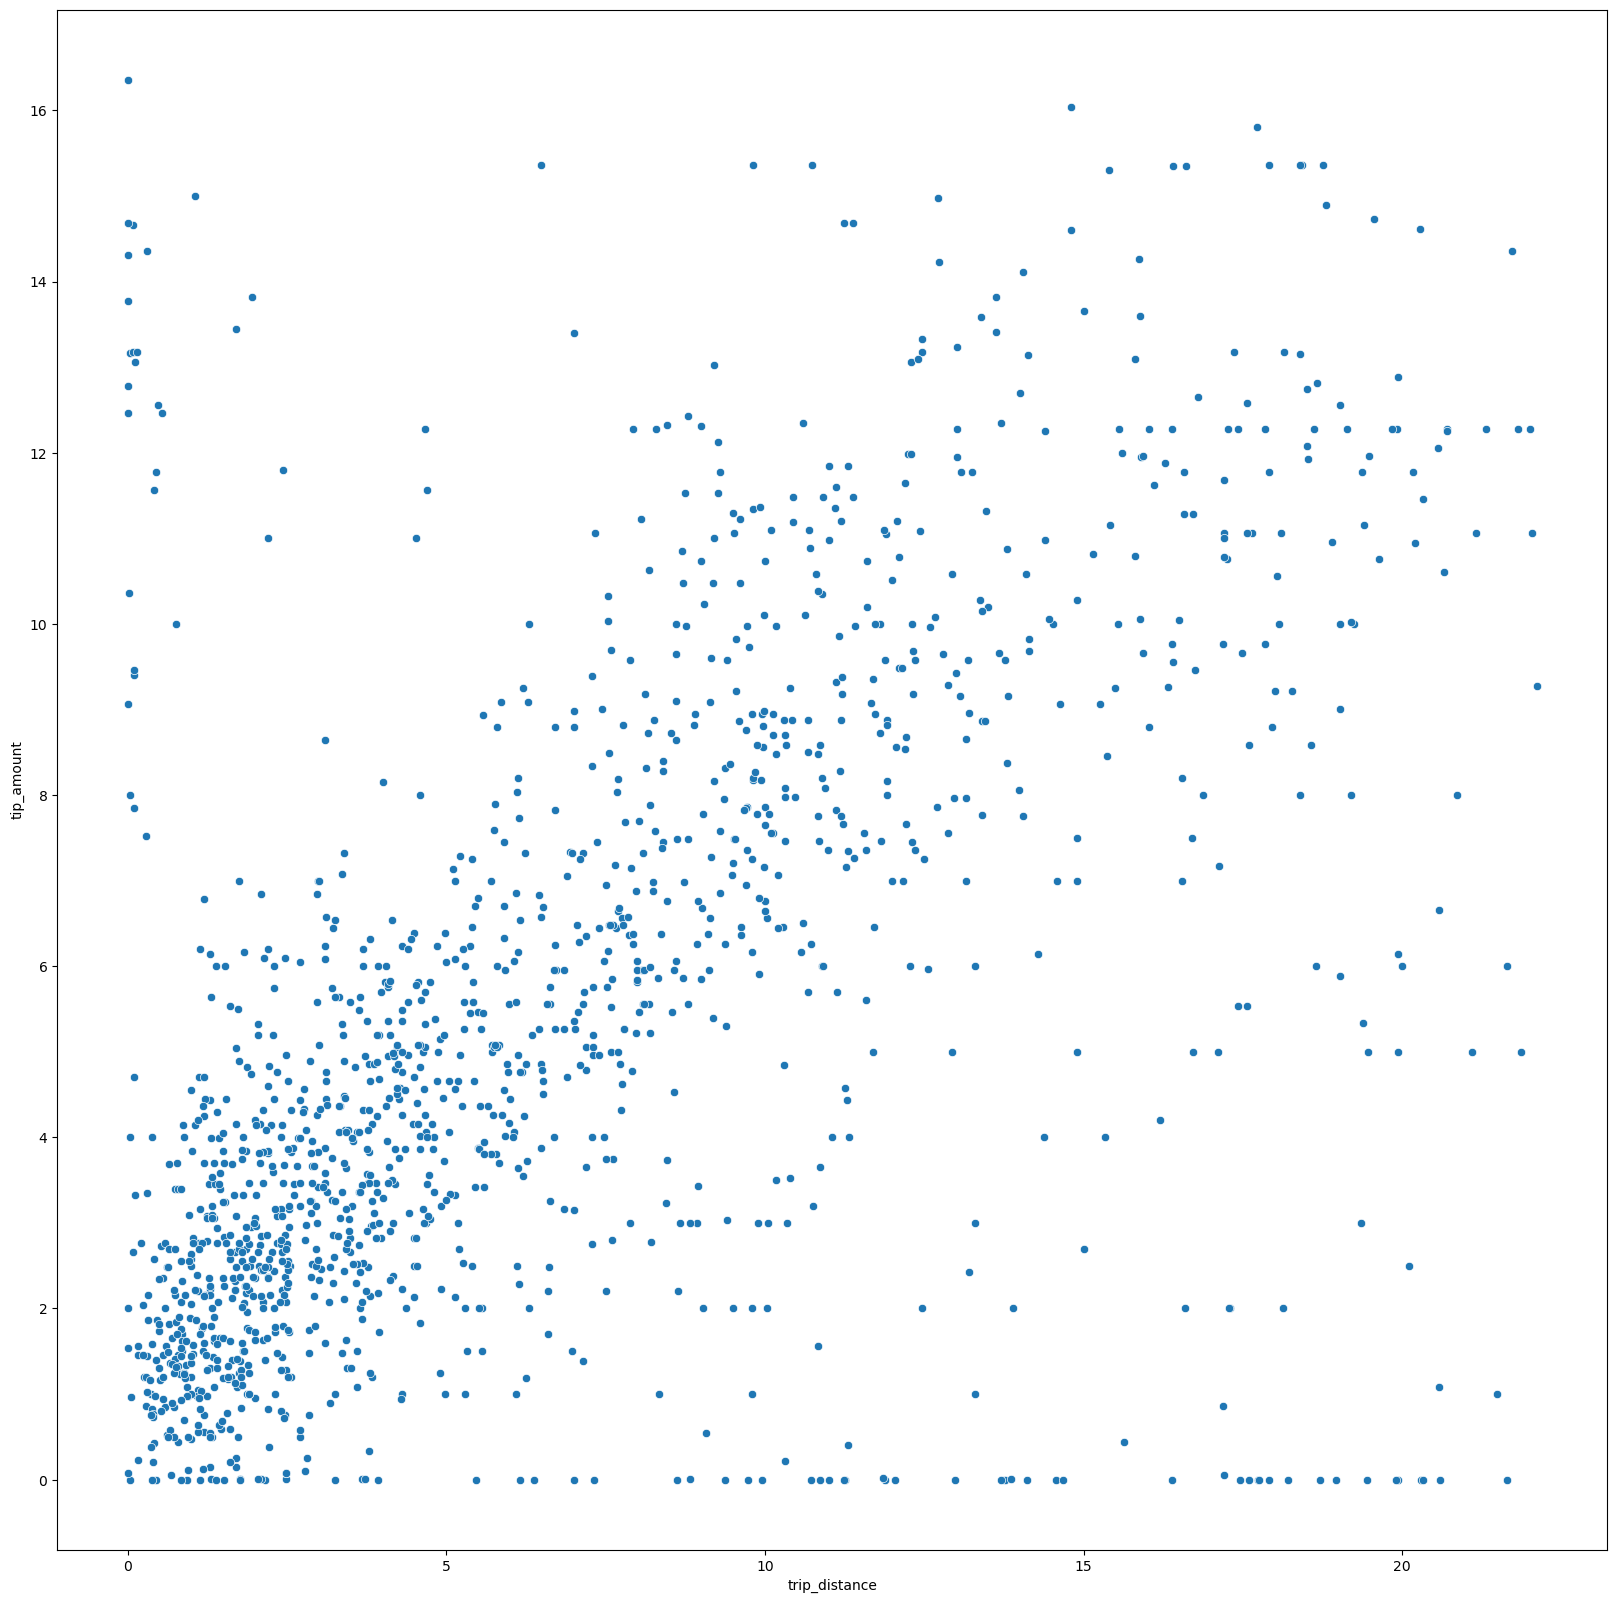

In [82]:
df_sample2 = df_sample.sample(1500)

fig, scatter = plt.subplots(figsize = (20,20))
sns.scatterplot(x="trip_distance", y="tip_amount", palette='deep',data=df_sample2)

## ---------------------------------------Попробуем pySpark


In [44]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
import matplotlib.pyplot as plt

In [45]:
spark = SparkSession.builder.appName("taxi_analyse").getOrCreate()

In [46]:
ds = spark.read.option("header",True).option("inferSchema", True).csv(r"D:\PROJECTS\Final_work\5_final_project\csv\taxi.csv")
ds.printSchema()

root
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)



In [47]:
ds = ds.drop("tpep_pickup_datetime", "fare_amount","total_amount")
ds.printSchema()

root
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- tip_amount: double (nullable = true)



In [48]:
ds=ds.distinct()

In [49]:
ds.describe().show()

+-------+------------------+-----------------+-----------------+
|summary|   passenger_count|    trip_distance|       tip_amount|
+-------+------------------+-----------------+-----------------+
|  count|            517155|           517155|           517155|
|   mean|2.2583500111185235|7.583832912840243|5.723245932152644|
| stddev|1.6703188726213414|292.4184807139178|5.809025557374859|
|    min|                 0|           -30.62|            -91.0|
|    max|                 9|        210240.06|           1100.0|
+-------+------------------+-----------------+-----------------+



удалим выбросы(также как и в Pandas) и отрицательные значения

In [52]:
ds = ds.filter((ds["trip_distance"] >= 0) & (ds["tip_amount"] >= 0))

In [53]:
Q1 = ds.approxQuantile("trip_distance", [0.25], 0)
Q3 = ds.approxQuantile("trip_distance", [0.75], 0)
IQR = Q3[0] - Q1[0]

lower_range = Q1[0] - 1.5 * IQR
upper_range = Q3[0] + 1.5 * IQR

ds = ds.filter((ds["trip_distance"] > lower_range) & (ds["trip_distance"] < upper_range))

Q1 = ds.approxQuantile("tip_amount", [0.25], 0)
Q3 = ds.approxQuantile("tip_amount", [0.75], 0)
IQR = Q3[0] - Q1[0]

lower_range = Q1[0] - 1.5 * IQR
upper_range = Q3[0] + 1.5 * IQR

ds = ds.filter((ds["tip_amount"] > lower_range) & (ds["tip_amount"] < upper_range))

In [54]:
ds.describe().show()

+-------+------------------+-----------------+------------------+
|summary|   passenger_count|    trip_distance|        tip_amount|
+-------+------------------+-----------------+------------------+
|  count|            479455|           479455|            479455|
|   mean|2.3085232190716543|6.267000740506826| 4.970652449244256|
| stddev|1.6852447813983928|5.213356153033247|3.4505403315176606|
|    min|                 0|              0.0|               0.0|
|    max|                 9|            20.91|             14.85|
+-------+------------------+-----------------+------------------+



Применим модель линейной регрессии для попытки предсказания значения чаевых по количеству пассажиров и пройденному расстоянию:

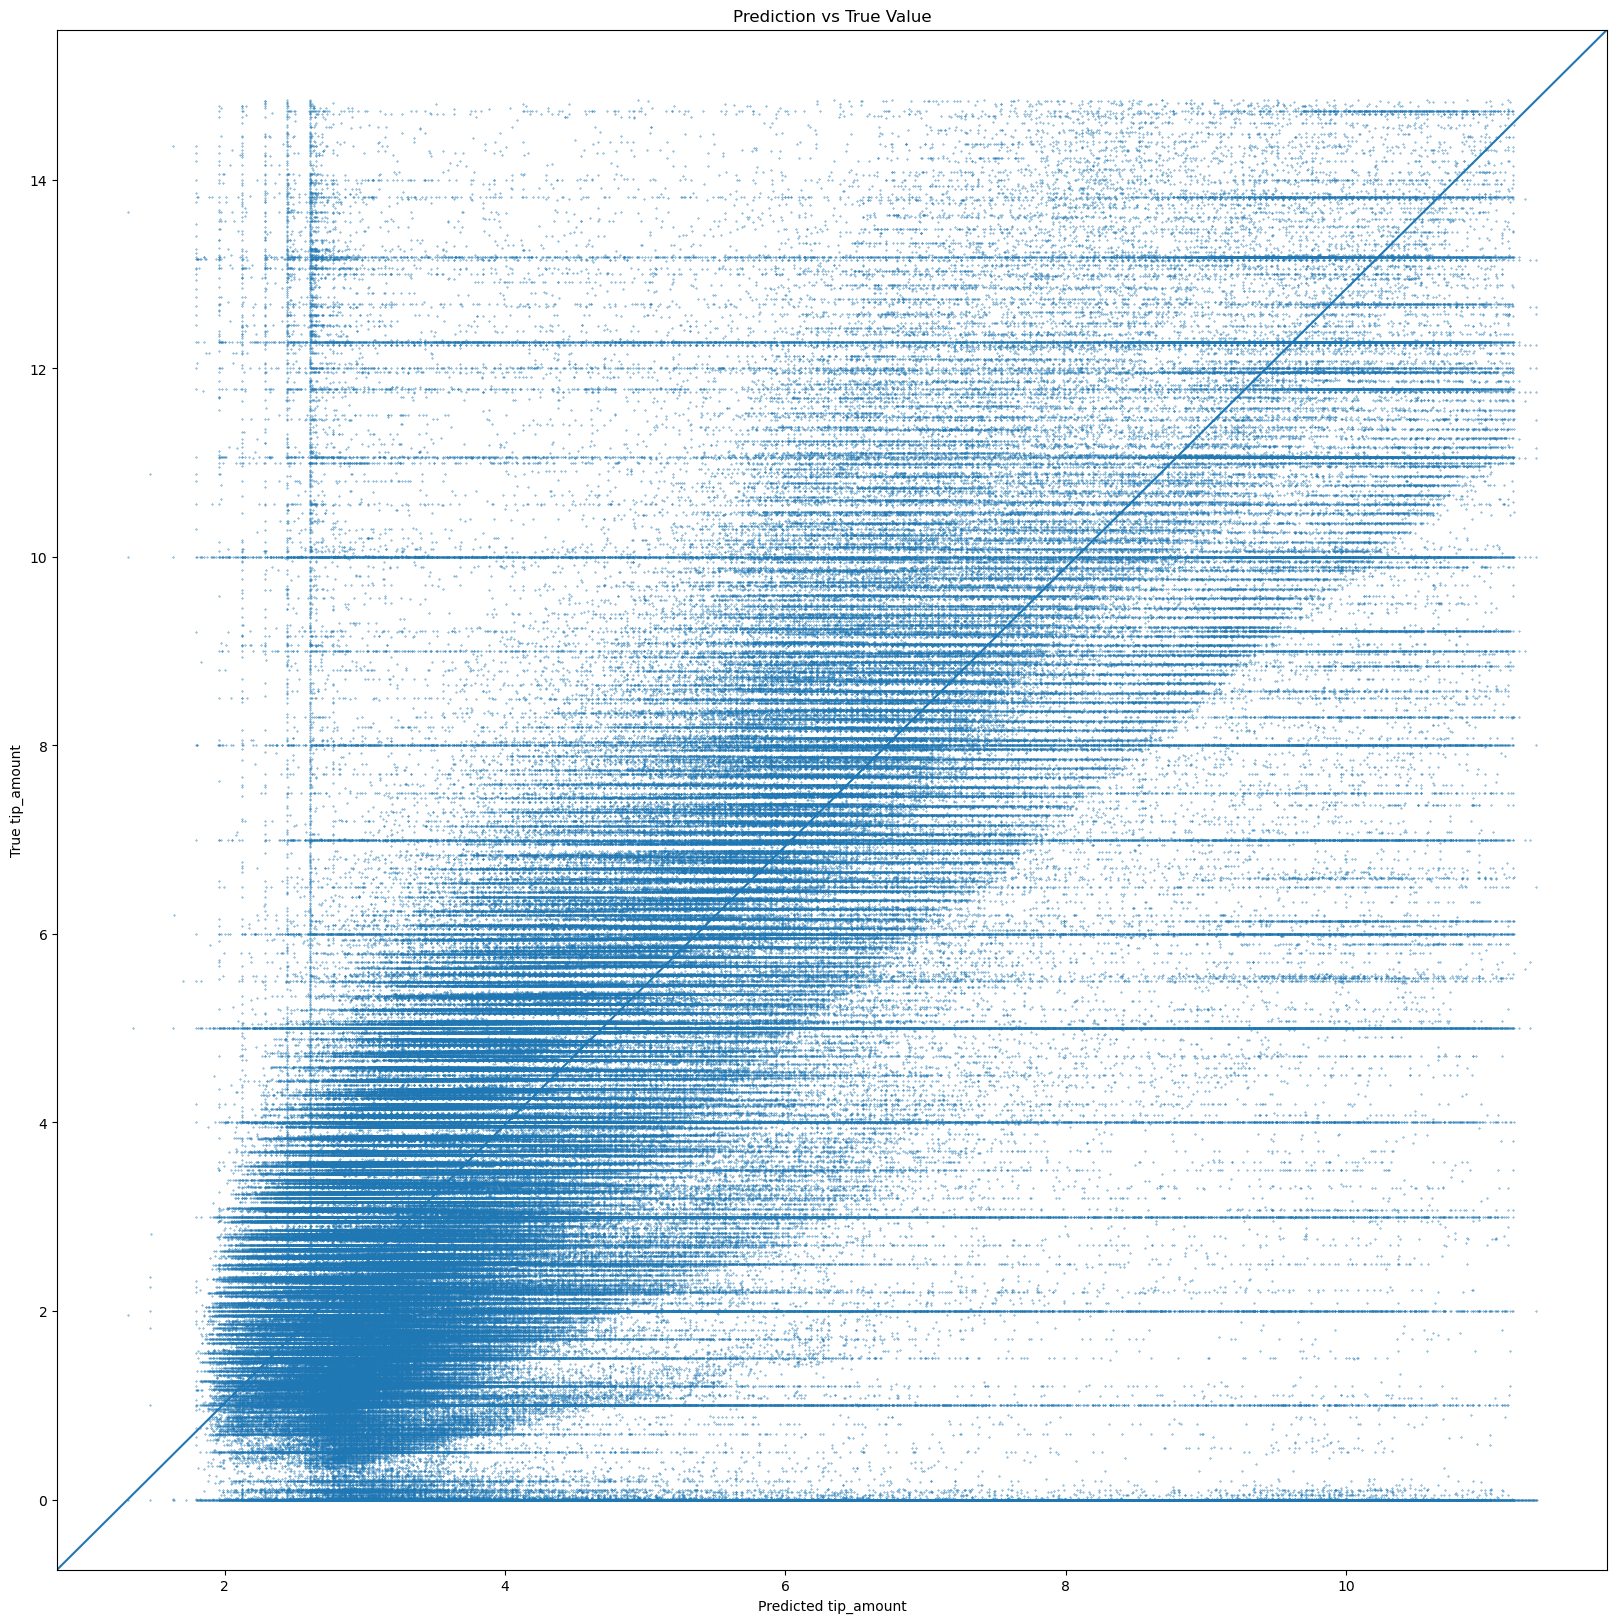

In [64]:
vectorAssembler = VectorAssembler(inputCols = ['passenger_count', 'trip_distance'], outputCol = 'features')
v_ds = vectorAssembler.transform(ds)

lr = LinearRegression(featuresCol = 'features', labelCol='tip_amount')
lr_model = lr.fit(v_ds)

predictions = lr_model.transform(v_ds)


pred_and_labels = predictions.select("prediction","tip_amount").collect()
fig, scatter = plt.subplots(figsize = (20,20))
plt.scatter([i[0] for i in pred_and_labels], [i[1] for i in pred_and_labels], s=0.1)
plt.xlabel('Predicted tip_amount')
plt.ylabel('True tip_amount')
plt.title('Prediction vs True Value')
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes)
plt.show()


In [65]:
print("коэффициенты: " + str(lr_model.coefficients))
print("свободный член: " + str(lr_model.intercept))

коэффициенты: [-0.16282773916423754,0.41083234225070114]
свободный член: 2.7718574727045433


коэффициенты и свободные члены уравнения прямой "аппроксимирующей" или пытающейся это сделать) 

In [57]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="tip_amount", predictionCol="prediction")

# Вычислите метрики
rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

print("RMSE: ", rmse)
print("MAE: ", mae)
print("R2: ", r2)

RMSE:  2.6562068761818853
MAE:  1.8849978232099802
R2:  0.40741523333197105


Вывод - модель модет "обьяснить" лишь 40% дисперсии чаевых на основе значений расстояния и количеситва пассажиров.Это видно исходя из графика, когда истиннные значения и предсказанные сильно разбросаны вокруг линии. В случае точной модели они были бы максимально близко к линии.

посмотрим зависимость только от расстояния поездки

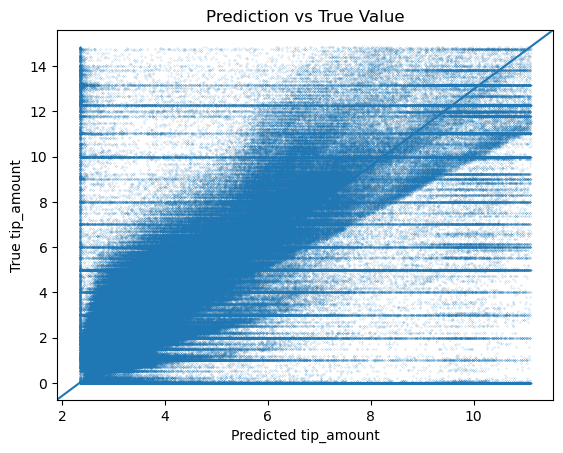

In [66]:
vectorAssembler = VectorAssembler(inputCols = ['trip_distance'], outputCol = 'features')
v_ds = vectorAssembler.transform(ds)

lr = LinearRegression(featuresCol = 'features', labelCol='tip_amount')
lr_model = lr.fit(v_ds)

predictions = lr_model.transform(v_ds)


pred_and_labels = predictions.select("prediction","tip_amount").collect()

plt.scatter([i[0] for i in pred_and_labels], [i[1] for i in pred_and_labels], s=0.01)
plt.xlabel('Predicted tip_amount')
plt.ylabel('True tip_amount')
plt.title('Prediction vs True Value')
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes)
plt.show()


In [68]:
print("коэффициент: " + str(lr_model.coefficients))
print("свободный член: " + str(lr_model.intercept))

коэффициент: [0.41925556333384373]
свободный член: 2.3431775233694503


Вывод: прослеживается слабая связь между пройденным расстоянием и величиной чаевых, которую можно попытаться описать уравнением вида tip_amount=0.41*trip_distance + 2.34
Вероятность предсказания правильного значения около 40%)

По графику ниже можно предположить что на расстоянии поездки от 0 до 5 км коэффициент для расчета чаевых от расстояния в среднем ближе к 1, от 5 до 10 км от снижается до 0,7, и свыше 10 км опродолжает снижаться. Но это лишь предположение на основе англомерации значений.

C:\Users\sever\AppData\Local\Temp\ipykernel_11536\1784052092.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="trip_distance", y="tip_amount", palette='deep',data=df_sample)


<Axes: xlabel='trip_distance', ylabel='tip_amount'>

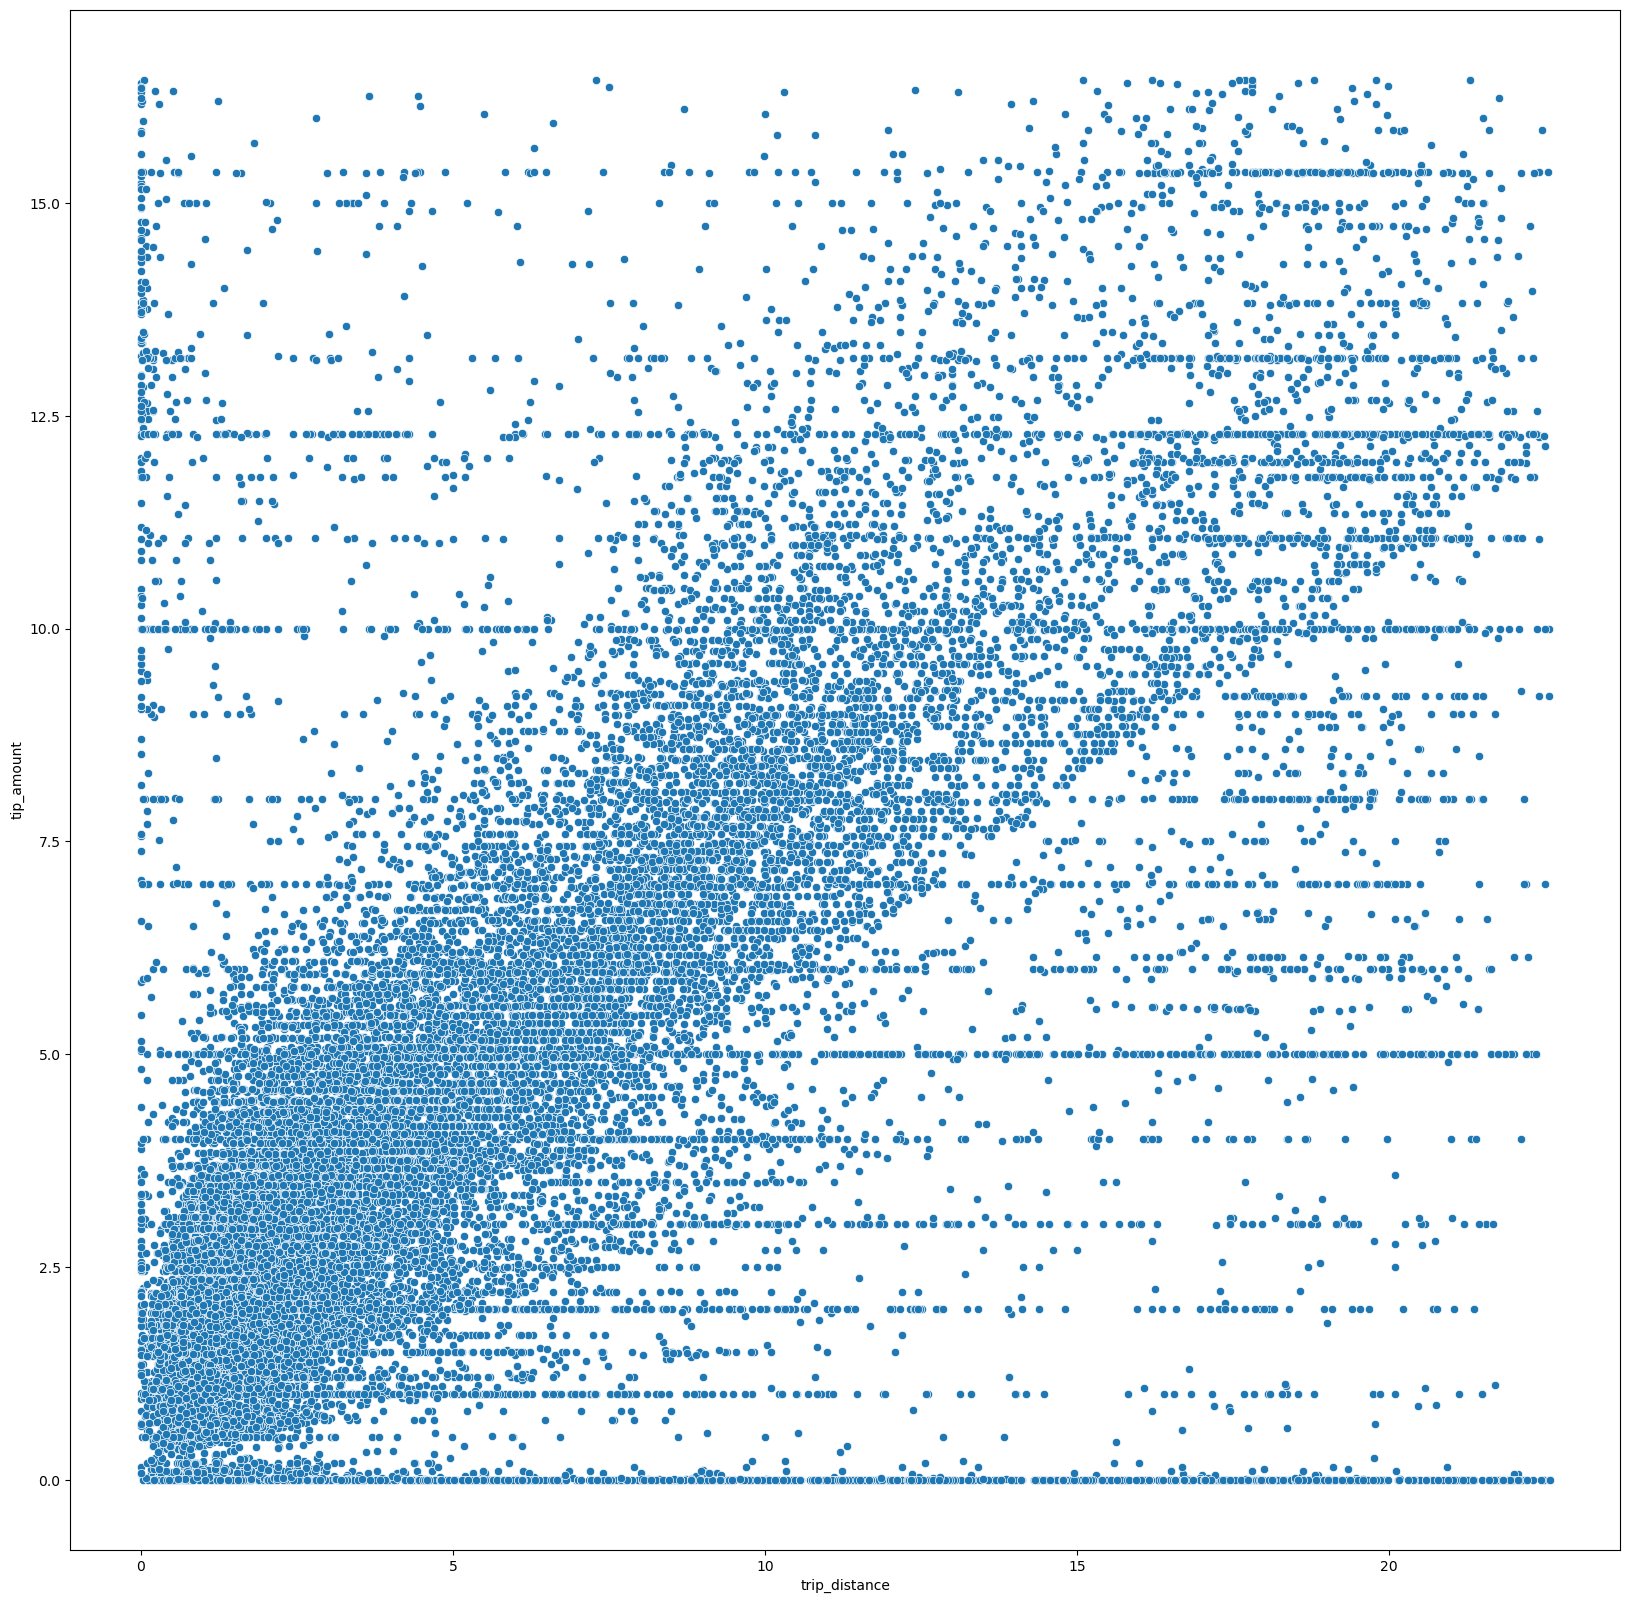

In [80]:
fig, scatter = plt.subplots(figsize = (20,20))
sns.scatterplot(x="trip_distance", y="tip_amount", palette='deep',data=df_sample)

На всякий случай график зависимости чаевых от количества пассажиров.

C:\Users\sever\AppData\Local\Temp\ipykernel_11536\2941429954.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="passenger_count", y="tip_amount", palette='deep',data=df_sample)


<Axes: xlabel='passenger_count', ylabel='tip_amount'>

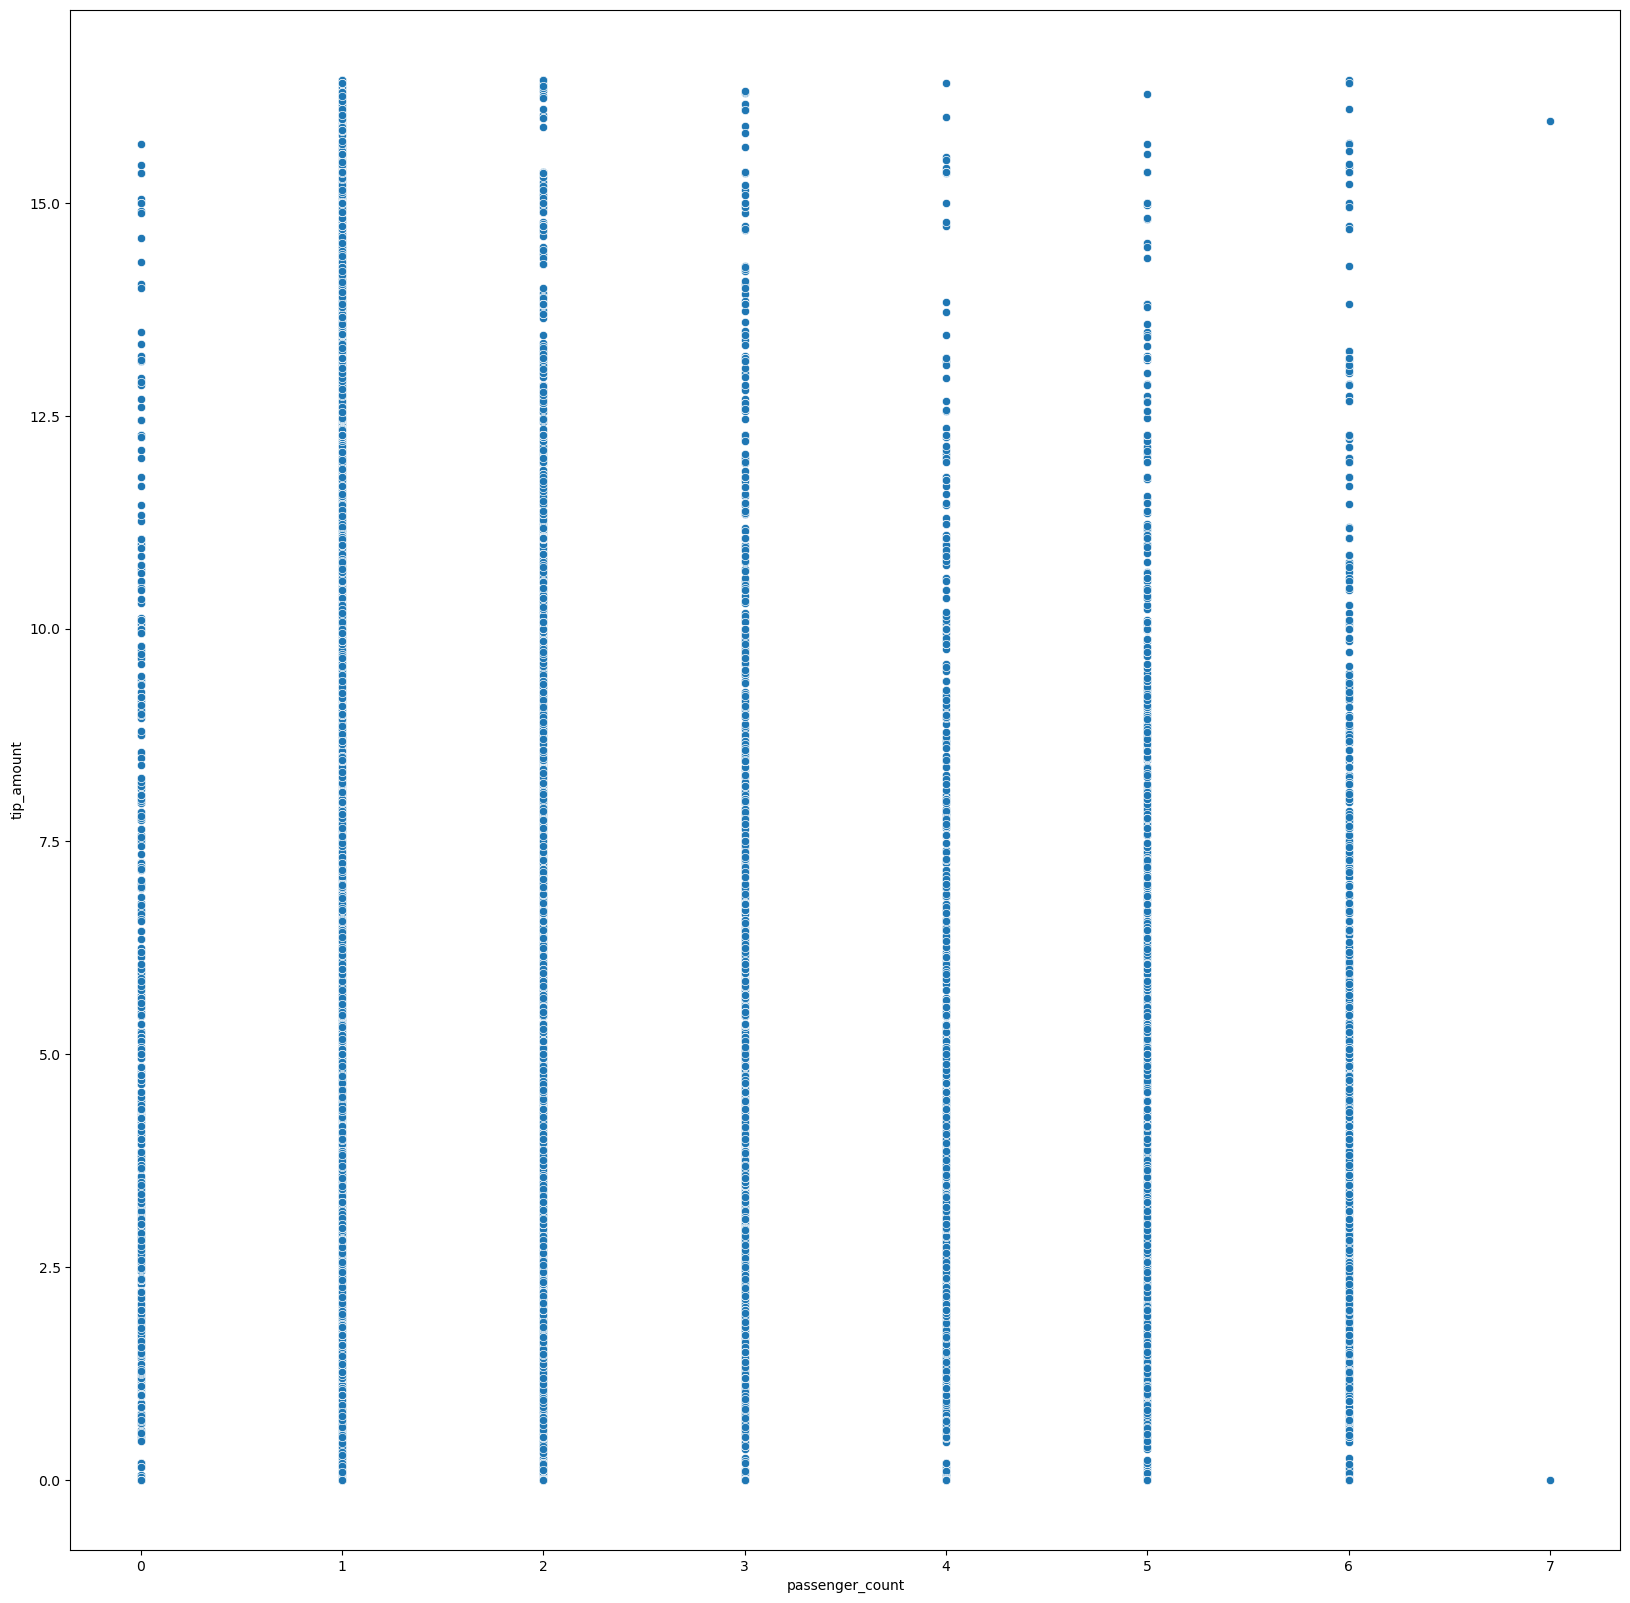

In [81]:
fig, scatter = plt.subplots(figsize = (20,20))
sns.scatterplot(x="passenger_count", y="tip_amount", palette='deep',data=df_sample)